### 課題名：　　　Kickstarter Projects  
目的：　　　　あるクラウドファンディングが成功するかを事前に予測するモデルを構築する  
氏名：　　　　Tokyo　ON　Line　太田拓男  
ファイル名：　Day3_work_太田拓男

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_recall_fscore_support
from IPython.core.display import display 
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from IPython.core.display import display 
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Ridge

# Data is downloaded and ready to use!
#df_data = pd.read_csv("../input/ks-projects-201801.csv")
df_data = pd.read_csv("../ks-projects-201801.csv")
print("Row lengths of imported data: ", len(df_data))


Row lengths of imported data:  378661


１．データのダウンロード

In [2]:
df_data=pd.read_csv("../ks-projects-201801.csv")
print("Row length of imported data:", len(df_data))

Row length of imported data: 378661


In [3]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


説明変数の確認  

ID　　　　　　   id                    
name　　　　　   プロジェクト名        
category         業態（カテゴリ）      
main_category　  資金調達するカテゴリ  
currency   　　　支援に使用された通貨  
state     　　　 プロジェクトの状況  
dead line  　　　ファンディング締切日  
goal　　　　　　 資金調達目標  
launched         公開日  
pledged　　　　　支援の集めた金額  
state　　　　　　プロジェクト状況  
backers　　　　  支援者数  
country　　　　　支援国  
usd pledged      支援金額（ドル)  
usd_pledged_real 達成金額（ドル)  
usd_goal_real　　目標金額（ドル） 

２．目的変数、説明変数の確認

In [4]:
display(df_data.head())
df_data.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


3．Stateの内容を確認する

In [5]:
print(df_data['state'].value_counts(dropna=False))
print("Stateの6項目のうち、'failed','successful'に注目する")

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64
Stateの6項目のうち、'failed','successful'に注目する


4．各説明変数と、Stateとの相関を確認する。

Categoryによる成功・不成功の傾向が見られる


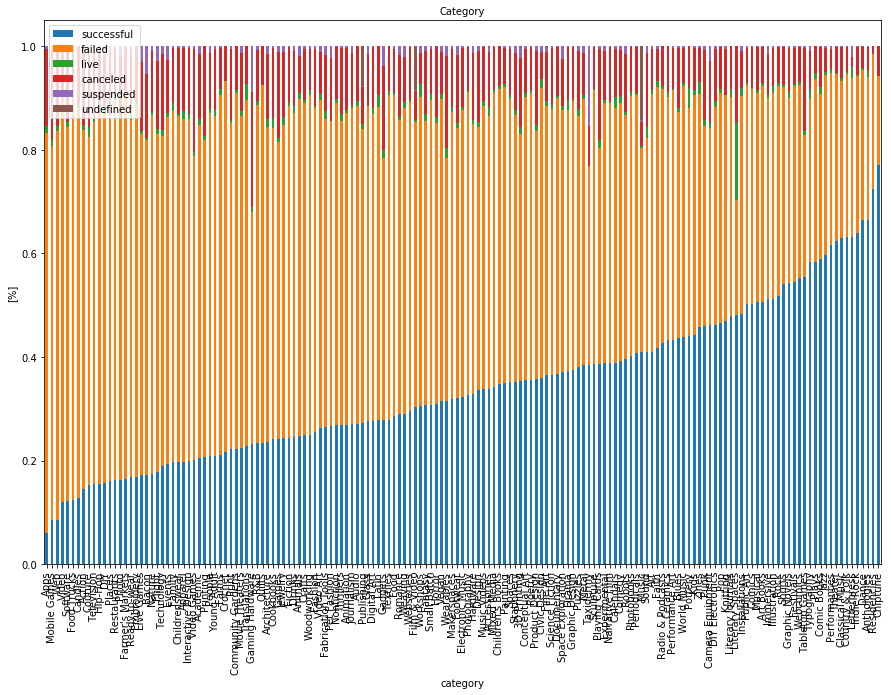

In [6]:
#Category毎のStateとの関係
category_=df_data.groupby('category')
category_=category_['state'].value_counts(normalize=True).unstack()
category_=category_.sort_values(by=['successful'],ascending=True)

category_[['successful','failed','live','canceled','suspended','undefined']].plot.bar(stacked=True,figsize=(15,10))
flg=10
fsz=10
lg=plt.legend(loc='upper left',fontsize=flg)
plt.title('Category',fontsize=fsz)
plt.xlabel("category",fontsize=fsz)
plt.ylabel("[%]",fontsize=fsz)
print("Categoryによる成功・不成功の傾向が見られる")

Main Categoryによる成功・不成功の傾向が見られる


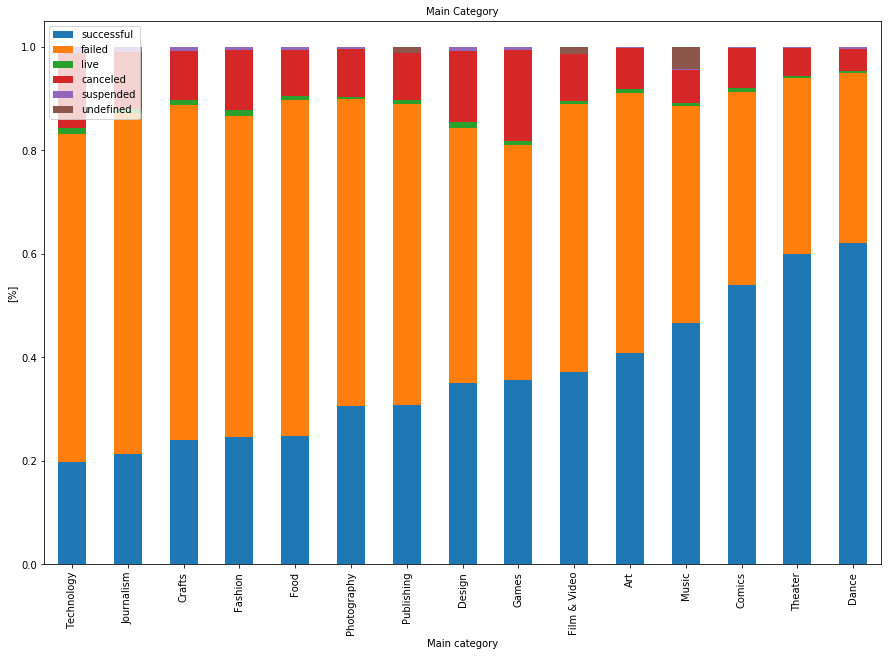

In [7]:
#main_category毎のStateとの関係
m_category_=df_data.groupby('main_category')
m_category_=m_category_['state'].value_counts(normalize=True).unstack()
m_category_=m_category_.sort_values(by=['successful'],ascending=True)

m_category_[['successful','failed','live','canceled','suspended','undefined']].plot.bar(stacked=True,figsize=(15,10))
flg=10
fsz=10
lg=plt.legend(loc='upper left',fontsize=flg)
plt.title('Main Category',fontsize=fsz)
plt.xlabel("Main category",fontsize=fsz)
plt.ylabel("[%]",fontsize=fsz)
print("Main Categoryによる成功・不成功の傾向が見られる")

通貨（Currency）により成功・不成功の差は見られる
ただし約２０～４０％の範囲であり、大きな差異ではないと考える 


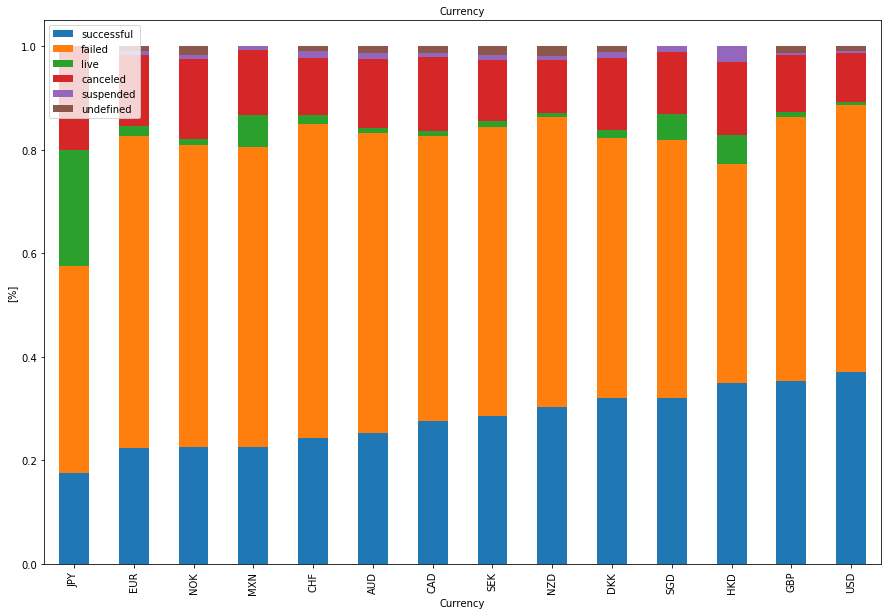

In [8]:
#通貨（currency）毎のStateとの関係
currency=df_data.groupby('currency')
currency=currency['state'].value_counts(normalize=True).unstack()
currency=currency.sort_values(by=['successful'],ascending=True)

currency[['successful','failed','live','canceled','suspended','undefined']].plot.bar(stacked=True,figsize=(15,10))
flg=10
fsz=10
lg=plt.legend(loc='upper left',fontsize=flg)
plt.title('Currency',fontsize=fsz)
plt.xlabel("Currency",fontsize=fsz)
plt.ylabel("[%]",fontsize=fsz)
print("通貨（Currency）により成功・不成功の差は見られる")
print("ただし約２０～４０％の範囲であり、大きな差異ではないと考える ")

daadline（ファンドの締め切り）と、成功率に関係性は見られない。2018年はLiveが多い


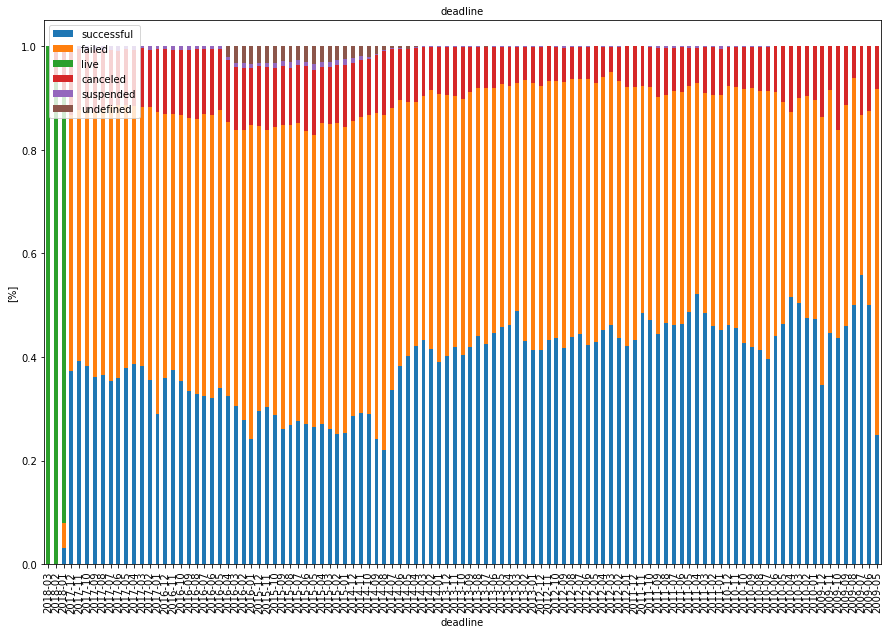

In [9]:
#deadline_YM毎のStateとの関係
df_data['deadline_YM'] = df_data['deadline'].apply(lambda x: x[0:7])

deadline_ = df_data.groupby('deadline_YM')
deadline_ = deadline_['state'].value_counts(normalize=True).unstack()
deadline_ = deadline_.sort_values('deadline_YM',ascending=False)

deadline_[['successful','failed','live','canceled','suspended','undefined']].plot.bar(stacked=True,figsize=(15,10))
flg=10
fsz=10
lg=plt.legend(loc='upper left',fontsize=flg)
plt.title('deadline',fontsize=fsz)
plt.xlabel("deadline",fontsize=fsz)
plt.ylabel("[%]",fontsize=fsz)
print("daadline（ファンドの締め切り）と、成功率に関係性は見られない。2018年はLiveが多い")

資金調達目標（goal)が大きいと、資金調達は困難になるのが確認できた


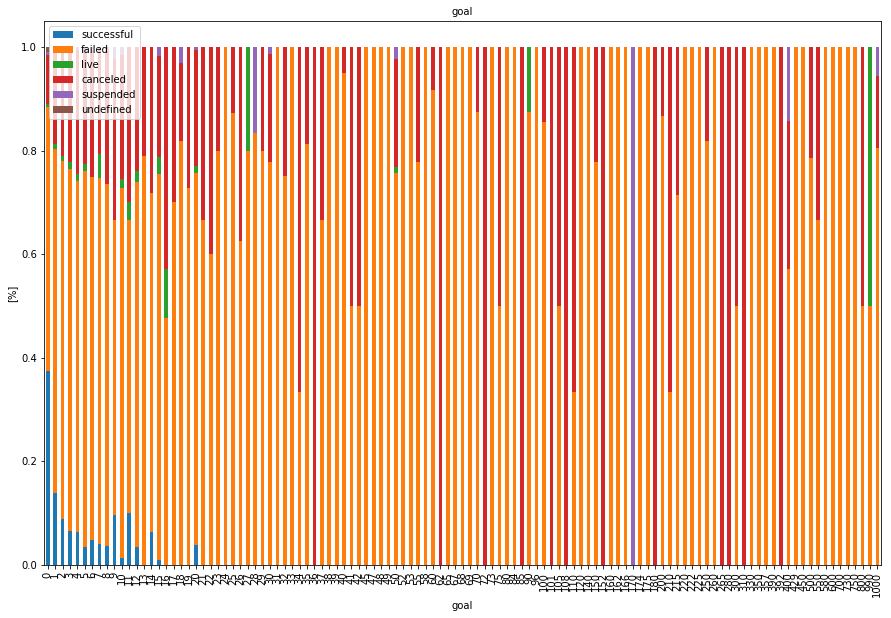

In [10]:
#goal毎のStateとの関係
#goal（資金到達目標）を１０万単位で丸め、傾向を確認する。
df_data['goal_r']=df_data['goal'].apply(lambda x: round(x/100000))
goal_=df_data.groupby('goal_r')
goal_=goal_['state'].value_counts(normalize=True).unstack()
goal_=goal_.sort_values('goal_r',ascending=True)
ax=goal_[['successful','failed','live','canceled','suspended','undefined']].plot.bar(stacked=True,figsize=(15,10))
flg=10
fsz=10
lg=plt.legend(loc='upper left',fontsize=flg)
plt.title('goal',fontsize=fsz)
plt.xlabel("goal",fontsize=fsz)
plt.ylabel("[%]",fontsize=fsz)
print("資金調達目標（goal)が大きいと、資金調達は困難になるのが確認できた")

2017年11月以降、Live割合が増える
1970.1～2000.1の間は成功なし、間隔も離れており異常値とする


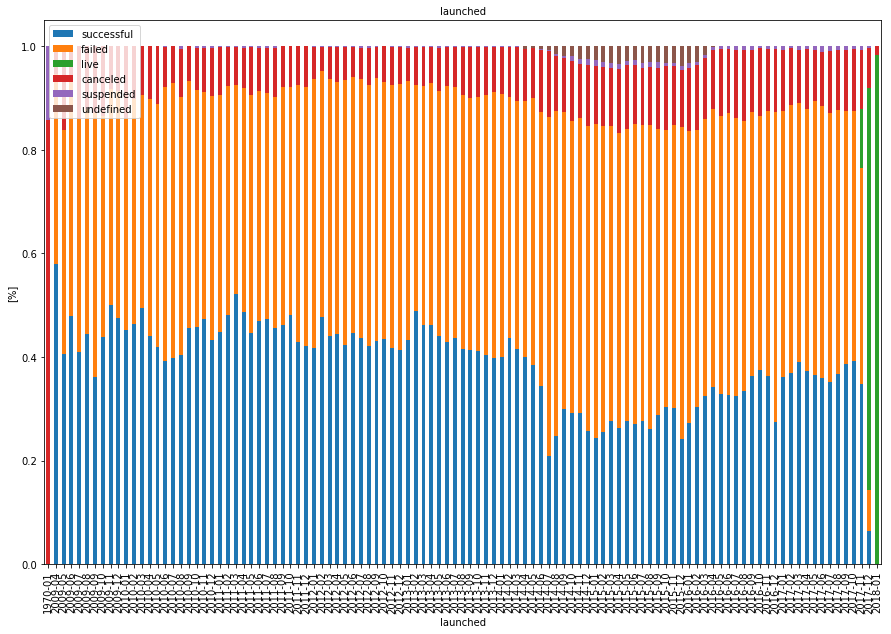

In [11]:
#launched毎のStateとの関係
df_data['launched_YM'] = df_data['launched'].apply(lambda x: x[0:7])
launched_ = df_data.groupby('launched_YM')
launched_ = launched_['state'].value_counts(normalize=True).unstack()
launched_ = launched_.sort_values('launched_YM',ascending=True)
ax=launched_[['successful','failed','live','canceled','suspended','undefined']].plot.bar(stacked=True,figsize=(15,10))
flg=10
fsz=10
lg=plt.legend(loc='upper left',fontsize=flg)
plt.title('launched',fontsize=fsz)
plt.xlabel("launched",fontsize=fsz)
plt.ylabel("[%]",fontsize=fsz)
print("2017年11月以降、Live割合が増える")
print("1970.1～2000.1の間は成功なし、間隔も離れており異常値とする")

Pledged(支援金額）が１０万S以下は、ほぼ失敗している。１０万＄以上になると、成功する傾向見られる


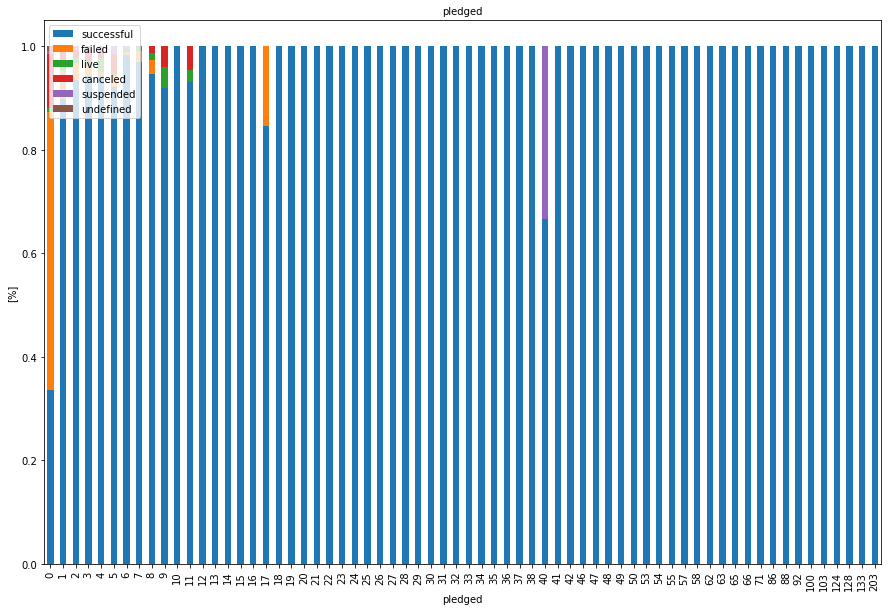

In [12]:
#pledged毎のStateとの関係
#pledge（資金到達目標）を１０万$単位で丸め、傾向を確認する。
df_data['pledged_r'] = df_data['pledged'].apply(lambda x: round(x/100000))
pledged_=df_data.groupby('pledged_r')
pledged_=pledged_['state'].value_counts(normalize=True).unstack()
pledged_=pledged_.sort_values('pledged_r',ascending=True)
ax=pledged_[['successful','failed','live','canceled','suspended','undefined']].plot.bar(stacked=True,figsize=(15,10))
flg=10
fsz=10
lg=plt.legend(loc='upper left',fontsize=flg)
plt.title('pledged',fontsize=fsz)
plt.xlabel("pledged",fontsize=fsz)
plt.ylabel("[%]",fontsize=fsz)
print("Pledged(支援金額）が１０万S以下は、ほぼ失敗している。１０万＄以上になると、成功する傾向見られる")

backers(支援者数）が1000人以下では成功率は約30%以下、1000人以上では成功率が著しく高まる)
10000人以下では成功、不成功以外の項目（異常値）が多いため、削除必要


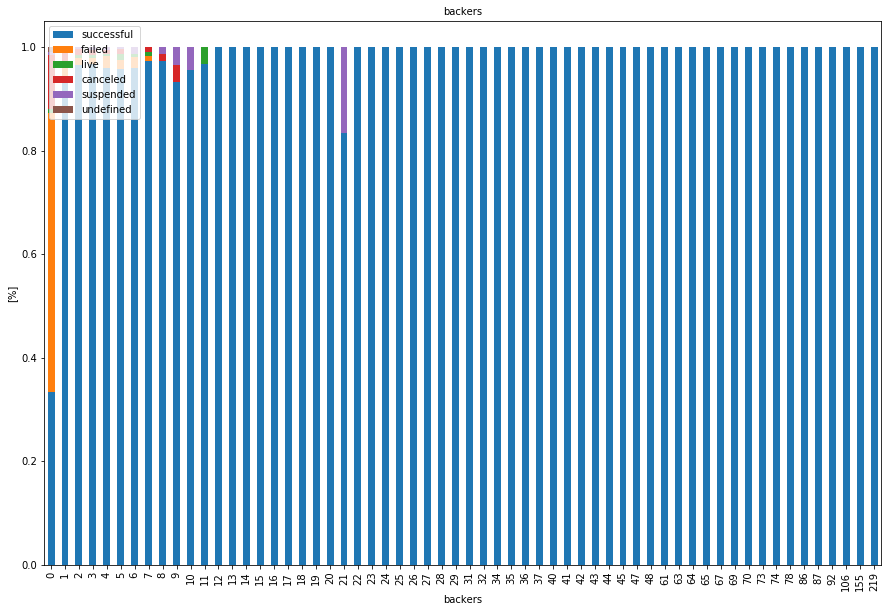

In [13]:
#backers(支援者数）毎のStateとの関係
#backers(支援者数）を1000単位で丸めて相関を見る
df_data['backers_r'] = df_data['backers'].apply(lambda x: round(x/1000))
backers_ = df_data.groupby('backers_r')
backers_ = backers_['state'].value_counts(normalize=True).unstack()
backers_ = backers_.sort_values('backers_r',ascending=True)
ax=backers_[['successful','failed','live','canceled','suspended','undefined']].plot.bar(stacked=True,figsize=(15,10))
flg=10
fsz=10
lg=plt.legend(loc='upper left',fontsize=flg)
plt.title('backers',fontsize=fsz)
plt.xlabel("backers",fontsize=fsz)
plt.ylabel("[%]",fontsize=fsz)
print("backers(支援者数）が1000人以下では成功率は約30%以下、1000人以上では成功率が著しく高まる)")
print("10000人以下では成功、不成功以外の項目（異常値）が多いため、削除必要")

country（支援国）により、成功率に違いは見られる。ただし大きな差異ではない
N.O.　異常値がある。削除必要


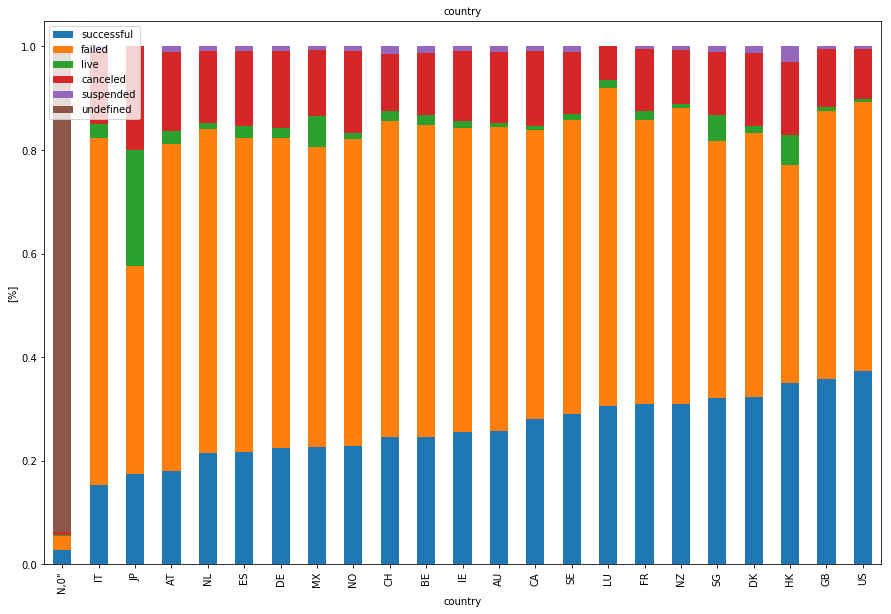

In [14]:
#country（支援国）毎のStateとの関係
country_ = df_data.groupby('country')
country_ = country_['state'].value_counts(normalize=True).unstack()
country_ = country_.sort_values(by=['successful'],ascending=True)
country_[['successful','failed','live','canceled','suspended','undefined']].plot.bar(stacked=True,figsize=(15,10))
flg=10
fsz=10
lg=plt.legend(loc='upper left',fontsize=flg)
plt.title('country',fontsize=fsz)
plt.xlabel('country',fontsize=fsz)
plt.ylabel('[%]',fontsize=fsz)
print("country（支援国）により、成功率に違いは見られる。ただし大きな差異ではない")
print("N.O.　異常値がある。削除必要")

usd pledged（支援金額）により、成功率に違いは見られる。ただし大きな差異ではない


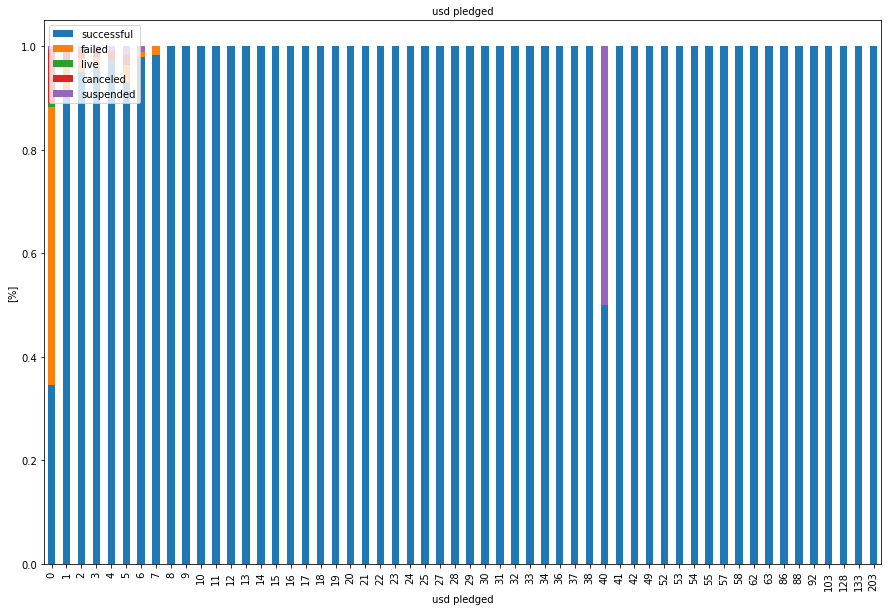

In [15]:
#usd pledged毎のStateとの関係
#usd pledgedを10万単位で丸めて相関を見る
df_data_t=df_data.dropna(subset=['usd pledged']).copy()
df_data_t['usd_pledged_r'] = df_data_t['usd pledged'].apply(lambda x: round(x/100000))
usd_pledged_=df_data_t.groupby('usd_pledged_r')
usd_pledged_=usd_pledged_['state'].value_counts(normalize=True).unstack()
usd_pledged_=usd_pledged_.sort_values('usd_pledged_r',ascending=True)
ax=usd_pledged_[['successful','failed','live','canceled','suspended']].plot.bar(stacked=True,figsize=(15,10))
flg=10
fsz=10
lg=plt.legend(loc='upper left',fontsize=flg)
plt.title('usd pledged',fontsize=fsz)
plt.xlabel("usd pledged",fontsize=fsz)
plt.ylabel("[%]",fontsize=fsz)
print("usd pledged（支援金額）により、成功率に違いは見られる。ただし大きな差異ではない")


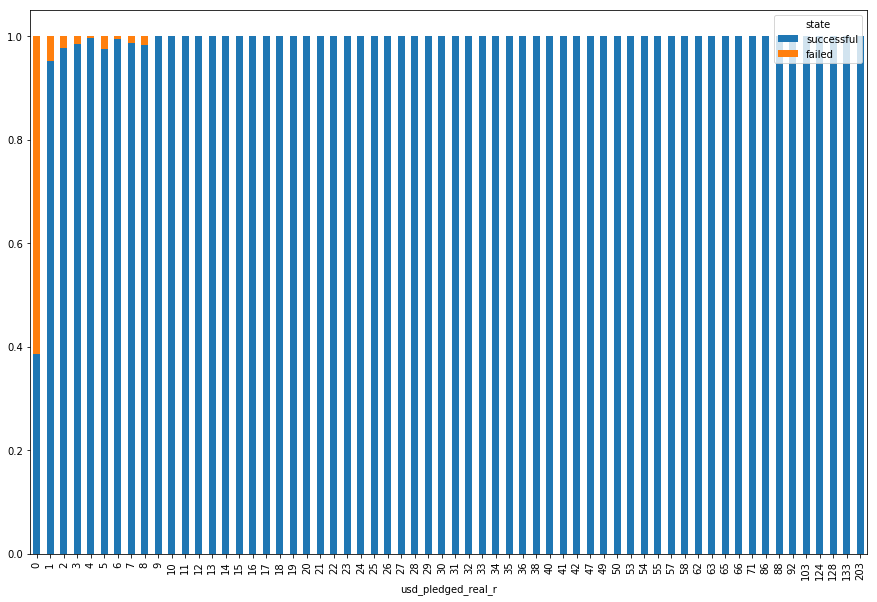

In [16]:
#usd_pledged_real毎のStateとの関係
#usd_pledged_realを10万単位で丸めて相関を見る
df_data['usd_pledged_real_r'] = df_data['usd_pledged_real'].apply(lambda x: round(x/100000))
df_data_and=df_data.query('state=="successful" | state=="failed" ')
usd_pledged_real_ = df_data_and.groupby('usd_pledged_real_r')
usd_pledged_real_ = usd_pledged_real_['state'].value_counts(normalize=True).unstack()
usd_pledged_real_ = usd_pledged_real_.sort_values('usd_pledged_real_r',ascending=True)
ax = usd_pledged_real_[['successful','failed']].plot.bar(stacked=True,figsize=(15,10))

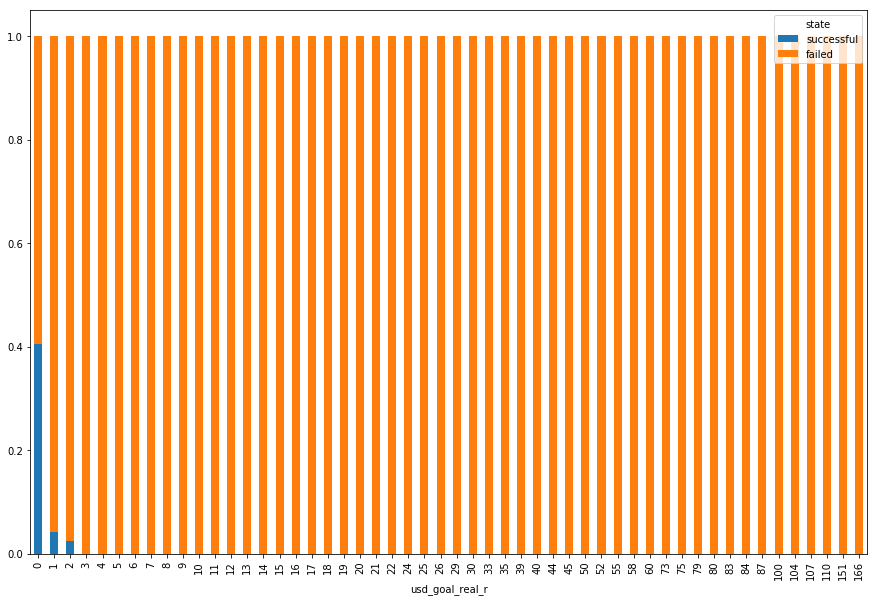

In [17]:
#usd_goal_real毎のStateとの関係
#usd_goal_realを1000000単位で丸めて相関を見る
df_data['usd_goal_real_r'] = df_data['usd_goal_real'].apply(lambda x: round(x/1000000))
df_data_and=df_data.query('state=="successful" | state=="failed" ')
usd_goal_real_ = df_data_and.groupby('usd_goal_real_r')
usd_goal_real_ = usd_goal_real_['state'].value_counts(normalize=True).unstack()
usd_goal_real_ = usd_goal_real_.sort_values('usd_goal_real_r',ascending=True)
ax = usd_goal_real_[['successful','failed']].plot.bar(stacked=True,figsize=(15,10))

5.説明変数同士の多重共線性の確認

In [18]:
#(1)categoryとmain categoryの関係
print('categoryとmain categoryの一覧表作成')
df_categories = df_data.groupby('category')
df_categories = df_categories['main_category'].value_counts(normalize=True).unstack(fill_value=0)
display(df_categories)

#categoryの種類と数を調べる
print('categoryの種類と数を調べる')
print(df_data['category'].value_counts(dropna=False))

#main_categoryの種類と数を調べる
print('main_categoryの種類と数を調べる')
print(df_data['main_category'].value_counts(dropna=False))

print('\n考察')
print('AnthologiesやSpacesのような一部の例外を除けば、categoryによりmain_categoryが一意に決まる')
print('多重共線性を考慮して、categoryに統一。説明変数からmain_categoryを削除する。')

categoryとmain categoryの一覧表作成


main_category,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
category,,,,,,,,,,,,,,,
3D Printing,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,1.000000,0.000000
Academic,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,1.000000,0.000000,0.000000
Accessories,0.0,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000
Action,0.0,0.000000,0.0,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000
Animals,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,1.0,0.000000,0.000000,0.000000
Animation,0.0,0.000000,0.0,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000
Anthologies,0.0,0.516582,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.483418,0.000000,0.000000
Apparel,0.0,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000
Apps,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,1.000000,0.000000


categoryの種類と数を調べる
Product Design       22314
Documentary          16139
Music                15727
Tabletop Games       14180
Shorts               12357
Video Games          11830
Food                 11493
Film & Video         10108
Fiction               9169
Fashion               8554
Nonfiction            8318
Art                   8253
Apparel               7166
Theater               7057
Technology            6930
Rock                  6758
Children's Books      6756
Apps                  6345
Publishing            6018
Webseries             5762
Photography           5752
Indie Rock            5657
Narrative Film        5188
Web                   5153
Comics                4996
Crafts                4664
Country & Folk        4451
Design                4199
Hip-Hop               3912
Hardware              3663
                     ...  
Couture                275
Blues                  268
Animals                255
Fabrication Tools      250
Makerspaces            238
Printing  

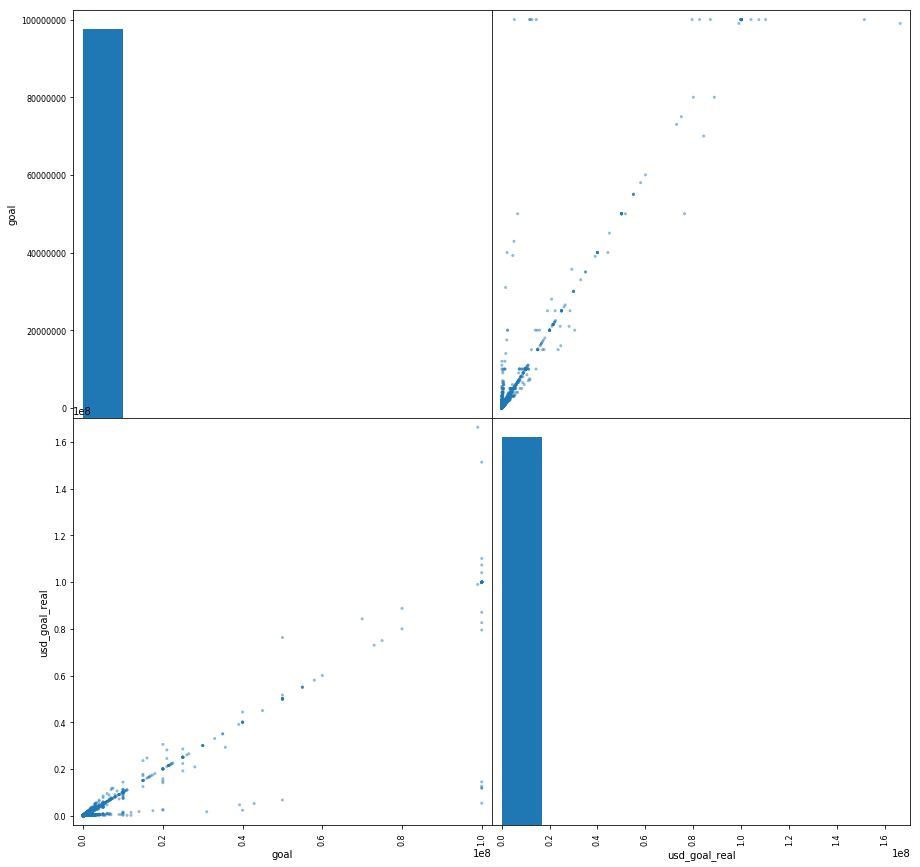

散布図により、goalとusd_goal_realには相関性が確認できる。
                   goal  usd_goal_real
goal           1.000000       0.942692
usd_goal_real  0.942692       1.000000
goal、usd_goalの相関係数は　0.94で極めて高い。
多重共線性を考慮して、goalに統一。説明変数からusd_goal_realを削除する


In [19]:
#(2)goalとusd_goal_realの関係
#散布図作成
import pandas as pd
import matplotlib.pyplot as plt
pd.plotting.scatter_matrix(df_data[['goal','usd_goal_real']], figsize=(15,15))
plt.show()
print('散布図により、goalとusd_goal_realには相関性が確認できる。')

#相関係数確認
corr_=df_data[['goal','usd_goal_real']].corr()

print(corr_)
print('goal、usd_goalの相関係数は　0.94で極めて高い。')
print('多重共線性を考慮して、goalに統一。説明変数からusd_goal_realを削除する')

In [20]:
#(3)countryとcurrencyの関係
print('currencyとcountryの一覧表作成')
df_currency_country = df_data.groupby('country')
df_currency_country = df_currency_country['currency'].value_counts(normalize=True).unstack(fill_value=0)
display(df_currency_country)
print('countryのうち、「N.O"]は異常値と考えられる。削除')

print('country（プロジェクトの支援国）の数を調べる')
print(df_data['country'].value_counts(dropna=False))

print('\n考察')
print('countryから異常値と思われる『N,0"』を除けば、countryによりcurrencyが決まる')
print('多重共線性を考慮して、countryに統一。説明変数からcurrencyを除外する')


currencyとcountryの一覧表作成


currency,AUD,CAD,CHF,DKK,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
country,,,,,,,,,,,,,,
AT,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
AU,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
BE,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
CA,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
CH,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
DE,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
DK,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
ES,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
FR,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000


countryのうち、「N.O"]は異常値と考えられる。削除
country（プロジェクトの支援国）の数を調べる
US      292627
GB       33672
CA       14756
AU        7839
DE        4171
N,0"      3797
FR        2939
IT        2878
NL        2868
ES        2276
SE        1757
MX        1752
NZ        1447
DK        1113
IE         811
CH         761
NO         708
HK         618
BE         617
AT         597
SG         555
LU          62
JP          40
Name: country, dtype: int64

考察
countryから異常値と思われる『N,0"』を除けば、countryによりcurrencyが決まる
多重共線性を考慮して、countryに統一。説明変数からcurrencyを除外する


説明変数として、4項目を採用する  
1.category  
2.goal  
3.backers  
4.country  

5.欠損値、異常値を確認、削除する

In [21]:
print('欠損値を確認する')
print(df_data.isnull().any(axis=0))
print('欠損値は nameおよびuesd_pledgedに生じている')
print('上記より、異常値は country,launched,backersにある')
print('欠測値、異常値を削除する')

欠損値を確認する
ID                    False
name                   True
category              False
main_category         False
currency              False
deadline              False
goal                  False
launched              False
pledged               False
state                 False
backers               False
country               False
usd pledged            True
usd_pledged_real      False
usd_goal_real         False
deadline_YM           False
goal_r                False
launched_YM           False
pledged_r             False
backers_r             False
usd_pledged_real_r    False
usd_goal_real_r       False
dtype: bool
欠損値は nameおよびuesd_pledgedに生じている
上記より、異常値は country,launched,backersにある
欠測値、異常値を削除する


In [22]:
df_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,usd pledged,usd_pledged_real,usd_goal_real,deadline_YM,goal_r,launched_YM,pledged_r,backers_r,usd_pledged_real_r,usd_goal_real_r
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,...,0.0,0.0,1533.95,2015-10,0,2015-08,0,0,0,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,...,100.0,2421.0,30000.00,2017-11,0,2017-09,0,0,0,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,...,220.0,220.0,45000.00,2013-02,0,2013-01,0,0,0,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,...,1.0,1.0,5000.00,2012-04,0,2012-03,0,0,0,0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,...,1283.0,1283.0,19500.00,2015-08,0,2015-07,0,0,0,0


In [23]:
print(df_data['state'].value_counts(dropna=False))

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64


In [24]:
df_data_1=df_data.copy()
df_data_1=df_data_1[df_data_1['state']!='live']
df_data_1=df_data_1[df_data_1['state']!='canceled']
df_data_1=df_data_1[df_data_1['state']!='suspended']
df_data_1=df_data_1[df_data_1['state']!='undefined']
df_data_1['Success']=df_data_1['state']=="successful"

In [25]:
df_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,usd pledged,usd_pledged_real,usd_goal_real,deadline_YM,goal_r,launched_YM,pledged_r,backers_r,usd_pledged_real_r,usd_goal_real_r
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,...,0.0,0.0,1533.95,2015-10,0,2015-08,0,0,0,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,...,100.0,2421.0,30000.00,2017-11,0,2017-09,0,0,0,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,...,220.0,220.0,45000.00,2013-02,0,2013-01,0,0,0,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,...,1.0,1.0,5000.00,2012-04,0,2012-03,0,0,0,0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,...,1283.0,1283.0,19500.00,2015-08,0,2015-07,0,0,0,0


In [26]:
# カテゴリー変数をダミー変数に変換
df_data_dummy1 = pd.get_dummies(df_data_1['category'])
df_data_1= pd.merge(df_data_1, df_data_dummy1, left_index=True, right_index=True)
df_data_dummy2 = pd.get_dummies(df_data_1['country'])
df_data_1 = pd.merge(df_data_1, df_data_dummy2, left_index=True, right_index=True)

# 欠測値/異常値/外れ値を削除する
#df_data = df_data[df_data['country'] != 'N,0"']
#df_data = df_data[df_data['launched'] > '2000-01-01']
#df_data = df_data[df_data['backers'] < 100000]

# 不要な列を削除する
#df_data = df_data.drop(['ID','name','category','main_category','currency'], axis=1)
#df_data = df_data.drop(['state','country','pledged','usd pledged','usd_pledged_real'], axis=1)
#df_data = df_data.drop(['deadline_YM','goal_r','launched_YM','pledged_r','backers_r','usd_pledged_real_r','usd_goal_real_r'], axis=1)


In [27]:
df_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Columns: 205 entries, ID to US
dtypes: bool(1), float64(5), int64(7), object(10), uint8(182)
memory usage: 126.1+ MB


In [28]:
df_data_1.head()  

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,JP,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,...,0,0,0,0,0,0,0,0,0,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,...,0,0,0,0,0,0,0,0,0,1
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,...,0,0,0,0,0,0,0,0,0,1
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,...,0,0,0,0,0,0,0,0,0,1
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,...,0,0,0,0,0,0,0,0,0,1


In [29]:
# Goalとusd_goal_realをInt化する
import numpy as np
df_data_1['goal'] = df_data_1['goal'].astype(np.int64)
df_data_1['usd_goal_real'] = df_data_1['usd_goal_real'].astype(np.int64)

In [30]:
df_data_1['launched']=pd.to_datetime(df_data_1['launched'])
df_data_1['deadline']=pd.to_datetime(df_data_1['deadline'])

df_data_1['duration_days']=df_data_1['deadline'].subtract(df_data_1['launched']).astype('timedelta64[D]')
df_data_1.drop(['launched', 'deadline'], axis=1, inplace=True)

In [31]:
df_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Columns: 204 entries, ID to duration_days
dtypes: bool(1), float64(4), int64(9), object(8), uint8(182)
memory usage: 123.6+ MB


In [32]:
df_data_1.head()

,ID,name,category,main_category,currency,goal,pledged,state,backers,country,...,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US,duration_days
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,1000,0.0,failed,0,GB,...,0,0,0,0,0,0,0,0,0,58.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,30000,2421.0,failed,15,US,...,0,0,0,0,0,0,0,0,1,59.0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,45000,220.0,failed,3,US,...,0,0,0,0,0,0,0,0,1,44.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,5000,1.0,failed,1,US,...,0,0,0,0,0,0,0,0,1,29.0
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,50000,52375.0,successful,224,US,...,0,0,0,0,0,0,0,0,1,34.0


In [33]:
# 不要な列を削除する
df_data_1 = df_data_1.drop(['ID','name','category','main_category','currency'], axis=1)
df_data_1 = df_data_1.drop(['state','country','pledged','usd pledged','usd_pledged_real'], axis=1)
df_data_1 = df_data_1.drop(['deadline_YM','goal_r','launched_YM','pledged_r','backers_r','usd_pledged_real_r','usd_goal_real_r'], axis=1)



In [34]:
df_data_1.head()

,goal,backers,usd_goal_real,Success,3D Printing,Academic,Accessories,Action,Animals,Animation,...,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US,duration_days
0,1000,0,1533,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,58.0
1,30000,15,30000,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,59.0
2,45000,3,45000,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,44.0
3,5000,1,5000,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,29.0
5,50000,224,50000,True,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,34.0


##標準化・正規化

In [35]:
#標準化
#from sklearn.preprocessing import StandardScaler

#stdsc=StandardScaler()
#scaler.fit(df_data_1)
#scaler.transform(df_data_1)
#df_data_1_std=pd.DataFrame(scaler.transform(df_data_1))

In [36]:
#df_data_1_std.describe()

In [37]:

Y=df_data_1['Success'].values
X=df_data_1.drop('Success',axis=1).values


In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=0.4, random_state=3)

In [40]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()

In [41]:
logreg.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [42]:
Y_pred=logreg.predict(X_test)

In [43]:
Y_pred

array([ True,  True, False, ..., False,  True, False])

In [44]:
from sklearn import metrics

In [45]:
metrics.accuracy_score(Y_test, Y_pred)

0.9068741991407251

In [46]:
#k近傍法

In [47]:
from sklearn.neighbors import KNeighborsClassifier

In [48]:
knn = KNeighborsClassifier(n_neighbors=6)

In [49]:
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform')

In [50]:
Y_pred=knn.predict(X_test)

In [51]:
metrics.accuracy_score(Y_test, Y_pred)

0.9052008743498907

In [52]:
#ロジスティック回帰

In [53]:
log_model=LogisticRegression()

In [54]:
log_model.fit(X,Y)#モデルを作る

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [55]:
log_model.score(X,Y)#モデルの精度

0.9041471319816085

In [56]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y)

In [57]:
log_model2=LogisticRegression()

In [58]:
log_model2.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [59]:
class_predict=log_model2.predict(X_test)#predict  予測する

In [60]:
class_predict

array([ True, False,  True, ...,  True, False,  True])

In [61]:
metrics.accuracy_score(Y_test, class_predict)

0.9047383591215523

#サポートベクタマシン

In [62]:
from sklearn.svm import SVC
model=SVC()
from sklearn.model_selection import train_test_split

In [63]:
model.fit(X_train,Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [64]:
from sklearn import metrics
predicted=model.predict(X_test)
expected=Y_test
print(metrics.accuracy_score(cxpected, predicted))

NameError: name 'cxpected' is not defined

In [ ]:
clf=SVC(gamma='auto')

In [ ]:
clf=SGDClassifier(loss='Log', penalty='none', max_iter=1000, fit_intercept=True,random_state=1234,tol=1e-3)
clf.fit()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix

In [ ]:
df_data_1.head()

In [ ]:
df_data_1.isnull()

##モデル生成

In [ ]:
y=df_data_1['Success'].values

In [ ]:
X=df_data.drop('Success').values

In [ ]:

#y=df_data['Success'].values

In [ ]:
X=df_data.drop('Success', axis=1).values

In [ ]:


def preprocessing_(df_data_test,\
                   stdsc=False, \
                   mms=False, \
                   decorre=False, \
                   show_decorre_detail = False, \
                   whitening=False \
                  ):
    
    if(decorre):
        if(show_decorre_detail):
            # goalとusd_goal_realを白色化
            print('goalとusd_goal_realの相関係数: {:.3f}'.format( \
                  np.corrcoef( \
                  df_data_test['goal'], \
                  df_data_test['usd_goal_real'])[0,1]))
        #  無相関化を行うための一連の処理
        cov = np.cov(df_data_test[['goal','usd_goal_real']], rowvar=0) # 分散・共分散を求める
        _, S = np.linalg.eig(cov)           # 分散共分散行列の固有ベクトルを用いて
        df_data_test[['goal','usd_goal_real']] = np.dot(S.T, df_data_test[['goal','usd_goal_real']].T).T #データを無相関化
        if(show_decorre_detail):
            print('無相関後のgoalとusd_goal_realの相関係数: {:.3f}'.format(np.corrcoef(df_data_test['goal'], df_data_test['usd_goal_real'])[0,1]))

    if(whitening):
        stdsc = True

    # 標準化とは、平均を引いて、標準偏差で割る操作
    if(stdsc):
        df_data_test = (df_data_test - df_data_test.mean()) / df_data_test.std()

    # 正規化とは、全データを0-1の範囲におさめる操作
    if(mms):
        min_max_scaler = MinMaxScaler()
        np_scaled = min_max_scaler.fit_transform(df_data_test)
        df_data_test = pd.DataFrame(np_scaled)

    return df_data_test
    
def logistic_(df_data_test):
    y = df_data_test['Success'].values
    X = df_data_test.drop('Success', axis=1).values
    clf = SGDClassifier(loss='log', penalty='none', fit_intercept=True, random_state=1234)
    clf.fit(X, y)
    y_est = clf.predict(X) # ラベルを予測
    return y, y_est

def cross_valid(df_data_test, \
                show_lap=False, \
                SGDClass_use = True, \
                lasso_use=False, \
                lasso_alpha=0, \
                ridge_use=False, \
                ridge_alpha=0, \
                stdsc=False, \
                mms=False, \
                decorre=False, \
                show_decorre_detail = False, \
                whitening=False, \
                DecisionTree_use=False, \
                RandomForest_use=False, \
                AdaBoost_use=False, \
                GradientBoost_use=False,\
                n_estimators=100, \
                min_samples_split=3, \
                min_samples_leaf=3, \
                max_depth=4 \
               ):
    # 絞った説明変数を使って，ロジスティック回帰
    y = df_data_test['Success'].values
    X = df_data_test.drop('Success', axis=1).values

    n_split = 5 # グループ数を設定（今回は5分割）
    cross_valid_loss = 0
    split_num = 1

    # テスト役を交代させながら学習と評価を繰り返す
    for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
        X_train, y_train = X[train_idx], y[train_idx] #学習用データ
        X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ

        # ここで前処理を行う
        X_train = preprocessing_(X_train, stdsc=stdsc, mms=mms, decorre=decorre, show_decorre_detail = show_decorre_detail, whitening=whitening)
        X_test = preprocessing_(X_test, stdsc=stdsc, mms=mms, decorre=decorre, show_decorre_detail = False, whitening=whitening)
        
        if(SGDClass_use):
            clf = SGDClassifier(loss='log', penalty='none', fit_intercept=True, random_state=1234)
        if(lasso_use):
            clf = Lasso(alpha=lasso_alpha)
        if(ridge_use):
            #clf = Ridge(alpha=ridge_alpha)
            clf = RidgeClassifier(alpha=ridge_alpha)
        if(DecisionTree_use):
            clf = DecisionTreeClassifier(criterion="gini", \
                                         max_depth=None, \
                                         min_samples_split=min_samples_split, \
                                         min_samples_leaf=min_samples_leaf, \
                                         random_state=1234)
        if(RandomForest_use):
            clf = RandomForestClassifier(n_estimators=n_estimators, \
                                         max_depth=max_depth, \
                                         criterion="gini", \
                                         min_samples_leaf=min_samples_leaf, \
                                         min_samples_split=min_samples_split, \
                                         random_state=1234)

        if(AdaBoost_use):
            clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                            min_samples_leaf=min_samples_leaf,
                                                            min_samples_split=min_samples_split, 
                                                            random_state=1234,
                                                            criterion="gini"),
                                                            n_estimators=n_estimators, 
                                     random_state=1234)
        if(GradientBoost_use):
            clf = GradientBoostingClassifier(n_estimators=n_estimators, 
                                             max_depth=max_depth, 
                                             criterion="friedman_mse", \
                                             min_samples_leaf=min_samples_leaf, 
                                             min_samples_split=min_samples_split, 
                                             random_state=1234)
            
        clf.fit(X_train, y_train)

        # テストデータでラベルを予測
        y_est_test = clf.predict(X_test)

        if(show_lap):
            # 対数尤度を表示
            loss_ = -log_loss(y_test, y_est_test)
            print("Fold %s"%split_num)
            print('各回の対数尤度 = {:.3f}'.format(loss_))
            cross_valid_loss += loss_ #後で平均を取るためにloss_を加算

        if(split_num==1):
            y_ = y_test
            y_est = y_est_test
        else:
            y_ = np.append(y_, y_test)
            y_est = np.append(y_est, y_est_test)
            #y_ = y_.append(y_test)
            #y_est = y_est.append(y_est_test)
            
        split_num += 1

    return y_, y_est
        

def show_results(y, y_est):
    # 対数尤度を表示
    print('対数尤度 = {:.3f}'.format(-log_loss(y, y_est)))

    # 正答率を計算
    accuracy =  accuracy_score(y, y_est)
    # Precision, Recall, F1-scoreを計算, 表示
    precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)
    print('正答率（Accuracy） = {:.3f}%, '.format(100 * accuracy), \
          '適合率（Precision） = {:.3f}%, '.format(100 * precision[0]) \
         )
    print('再現率（Recall） = {:.3f}%, '.format(100 * recall[0]), \
          'F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0])\
         )

    # 予測値と正解のクロス集計
    print('予測値と正解のクロス集計')
    conf_mat = pd.DataFrame(confusion_matrix(y, y_est), index=['正解 = 0', '正解 = 1'], columns=['予測値 = 0', '予測値 = 1'])
    print(conf_mat)
    

In [ ]:
df_data_test.head()

これより各種手法で予測精度を確認する

In [ ]:
print("最も基本となる方法で正答率を求める\n")
# データ作成関数を呼ぶ
df_data_test_4 = make_test_data(show_comment=True, show_data=True)

# 絞った説明変数を使って，ロジスティック回帰
# 基本的にクロスバリデーションで評価する
y, y_est = cross_valid(df_data_test_4)

# 結果を表示
show_results(y, y_est)

正規化、標準化の効果を見る

In [ ]:
print('まずは正規化から')
# データ作成関数を呼ぶ
df_data_test_8_3a1 = make_test_data(show_data=False)
# 絞った説明変数を使って，ロジスティック回帰
y, y_est = cross_valid(df_data_test_8_3a1, stdsc=True, mms=False)
# 結果を表示
show_results(y, y_est)

print('\n次に標準化')
# データ作成関数を呼ぶ
df_data_test_8_3a2 = make_test_data(show_data=False)
# 絞った説明変数を使って，ロジスティック回帰
y, y_est = cross_valid(df_data_test_8_3a2, stdsc=False, mms=True)
# 結果を表示
show_results(y, y_est)

print('\n結果、標準化・正規化とも正答率が上がり、標準化の方が効果が高いようだ')
print('以降、標準化をデフォルトで実施する')

Ridge（L2正則化）を例に正則化を行ってみる
交差検証によるパラメータチューニングを行う
その後、パラメータチューニング後のモデルによって、精度および結果の評価を行う

In [ ]:
print('Ridge（L2正則化）を例に正則化を行ってみる')
from sklearn.linear_model import RidgeClassifier

# データ作成関数を呼ぶ
df_data_test_8_3c1 = make_test_data()

# Test用データを分離する
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
dataset_train, dataset_test, dummy_train, dummy_test = \
train_test_split(df_data_test_8_3c1, df_data_test_8_3c1, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

# パラメータ検証用のクロスバリデーションを実施
alphas = [0, 0.0005, 0.001, 0.005, 0.01] #alpha(数式ではλ)の値を4つ指定する
n_split = 5 # グループ数を設定（今回は5分割）
cross_valid_losses = []
print("Alphas = ", alphas)

for alpha in alphas:
    cross_valid_loss = 0
    split_num = 1

    # テスト役を交代させながら学習と評価を繰り返す
    y, y_est = cross_valid(dataset_train, mms=True, SGDClass_use=False, ridge_use=True, ridge_alpha=alpha)
    # 結果を表示
    print("\nAlpha = %s"%alpha)
    show_results(y, y_est)

# Best Scoreを表示
alpha=0.001
print("\nBest Alpha = %s"%alpha)
y, y_est = cross_valid(dataset_test, mms=True, SGDClass_use=False, ridge_use=True, ridge_alpha=alpha)
show_results(y, y_est)
    
#結果
print('幅広くパラメータを試した結果、alpha=0.001前後に対数尤度が最も小さくなり、正答率も上がった') 

木モデルを用いる
決定木を用いる
ランダムフォレストを用いる
アダブーストを用いる
勾配ブースティングを用いる

In [ ]:
from sklearn.tree import DecisionTreeClassifier
print('まずは決定木を用いる')
print('木モデルなので、標準化は用いない')
# データ作成関数を呼ぶ
df_data_test_10_2_1 = make_test_data(show_data=False)
# クロスバリデーションで学習及び予測
y, y_est = cross_valid(df_data_test_10_2_1, mms=False, SGDClass_use=False, DecisionTree_use=True)
# 結果を表示
show_results(y, y_est)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
print('次にランダムフォレストを用いる')
# データ作成関数を呼ぶ
df_data_test_10_2_1 = make_test_data(show_data=False)
# クロスバリデーションで学習及び予測
y, y_est = cross_valid(df_data_test_10_2_1, mms=False, SGDClass_use=False, RandomForest_use=True)
# 結果を表示
show_results(y, y_est)

In [ ]:
from keras import optimizers
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
# AdaBoost Classification
import pandas
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier

print('その次は、アダブーストを用いる')
# データ作成関数を呼ぶ
df_data_test_10_2_1 = make_test_data(show_data=False)
# クロスバリデーションで学習及び予測
y, y_est = cross_valid(df_data_test_10_2_1, mms=False, SGDClass_use=False, AdaBoost_use=True)
# 結果を表示
show_results(y, y_est)


In [ ]:
print('木モデルの最後として、勾配ブースティングを用いる')
import pandas
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingClassifier



# データ作成関数を呼ぶ
df_data_test_10_2_1 = make_test_data(show_data=False)
# クロスバリデーションで学習及び予測
y, y_est = cross_valid(df_data_test_10_2_1, mms=False, SGDClass_use=False, GradientBoost_use=True)
# 結果を表示
show_results(y, y_est)


ニューラルネットワークを用いる

In [ ]:
from keras import optimizers
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
from keras.utils import np_utils
import warnings
warnings.filterwarnings('ignore')

print('ニューラルネットワークを用いる')
# データ作成関数を呼ぶ
df_data_test_10_3 = make_test_data()

# モデルを作成する
model = Sequential()
model.add(Dense(6, activation='relu', input_dim=185))
model.add(Dense(12, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(2, activation='softmax'))#最終層のactivationは変更しないこと
# ------ 最適化手法 ------
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

y = df_data_test_10_3['Success'].values
X = df_data_test_10_3.drop('Success', axis=1).values

n_split = 5 # グループ数を設定（今回は5分割）
cross_valid_loss = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ

    # ここで前処理を行う
    X_train = preprocessing_(X_train, mms=True)
    X_test = preprocessing_(X_test, mms=True)
        
    # one-hotベクトルに変換
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    
    #学習する        
    fit = model.fit(X_train, y_train,
                    epochs=300,
                    batch_size=3000,validation_data=(X_test, y_test))

    # 各epochにおける損失と精度をdfに入れる
    df = pd.DataFrame(fit.history)

    # グラフ化
    df[["loss", "val_loss"]].plot()
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.show()

    df[["acc", "val_acc"]].plot()
    plt.ylabel("acc")
    plt.xlabel("epoch")
    plt.ylim([0,1.0])
    plt.show()

    # テストデータでラベルを予測
    y_test_est = np.array(np.argmax(model.predict(X_test),axis=1), dtype='bool')
    y_test = np.array(np.argmax(y_test,axis=1), dtype='bool')

    if(split_num==1):
        y_ = y_test
        y_est = y_test_est
    else:
        y_ = np.append(y_, y_test)
        y_est = np.append(y_est, y_test_est)
            
    split_num += 1

show_results(y_, y_est)


まとめ
様々な方法で学習した結果の正答率を比較する、評価にはクロスバリデーションを用いている。
●ロジスティック回帰
１．基本形：50.600%
2a．正規化：54.728%
2b. 標準化：67.462%
３．標準化＋R2正則化：67.758%
●木モデル
１．決定木：91.397%
２．ランダムフォレスト：81.042%
３．アダブースト：93.156%
４．勾配ブースティング：93.082%
●ニューラルネット
１．標準化＋全結合4層：91.419%
このケースでは、『木モデル』との相性が良いようで、アダブーストで93%超の正答率を記録した。『木モデル』においてパラメータチューニングすれば、更に高い正答率が得られたかもしれない。¶